# Programação Genética

 - $[x]$ Código inicial
 - $[x]$ Desenhar circuito
 - $[x]$ Descobrir o motivo de estar tendendo a zero
 - $[ ]$ Tolerância precisão (5%, 10%)
 - $[ ]$ Limitar máximo de resistores (profundidade da árvore)
   - $max = h²$
 - $[ ]$ Adicionar no fitness minimização de número de resistores
 

In [1]:
# http://deap.readthedocs.io/en/master/examples/index.html
# http://deap.readthedocs.io/en/master/tutorials/advanced/gp.html?highlight=genFull

# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


import matplotlib.pyplot as plt
plt.style.use('ggplot')

from deap import gp

### Parâmetros globais

In [2]:
# Alterar valor de resistência para https://pypi.python.org/pypi/Unum/4.1.0
resistores = [2.2e3, 1e3, 10e3]
#resistencia_equivalente = 12.221e3
resistencia_equivalente = 129765

tolerancia = .05

### Operações e terminais

In [3]:
class ResistenciaEquivalenteOperador:
    
    @staticmethod
    def serie(a, b):
        return a + b

    @staticmethod
    def paralelo(a, b):
        return (a * b) / (a + b)
        
    @staticmethod
    def funcao_avaliacao(individuo):
        resultado = toolbox.compilar(expr=individuo)

        return abs(resistencia_equivalente - resultado),

In [4]:
primitive_set = gp.PrimitiveSet(name="MAIN", arity=0, prefix="IN")

primitive_set.addPrimitive(ResistenciaEquivalenteOperador.serie, 2)
primitive_set.addPrimitive(ResistenciaEquivalenteOperador.paralelo, 2)

for resistor in resistores:
    primitive_set.addTerminal(resistor)

### Criação de indivíduo, expressão e definição de fitness

In [5]:
from deap import base, creator

creator.create("FitnessMinimo", base.Fitness, weights=(-1.0,))
creator.create("Individuo", gp.PrimitiveTree, fitness=creator.FitnessMinimo)

In [6]:
from deap import tools

toolbox = base.Toolbox()
toolbox.register("expressao", gp.genFull, pset=primitive_set, min_=2, max_=3)
toolbox.register("individuo", tools.initIterate, creator.Individuo, toolbox.expressao)

### Populacao

In [7]:
toolbox.register("populacao", tools.initRepeat, list, toolbox.individuo)

toolbox.register("compilar", gp.compile, pset=primitive_set)

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

def show_expressao(expressao):
    nodes, edges, labels = gp.graph(expressao)

    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = graphviz_layout(g, prog="dot")

    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)
    plt.show()

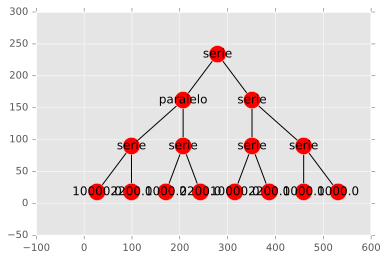

In [9]:
expressao = toolbox.expressao()
show_expressao(expressao)

In [10]:
tree = gp.PrimitiveTree(expressao)
str(tree)

'serie(paralelo(serie(10000.0, 2200.0), serie(1000.0, 2200.0)), serie(serie(10000.0, 2200.0), serie(1000.0, 1000.0)))'

In [11]:
toolbox.compilar(tree, pset=primitive_set)

16735.064935064936

### Evolução

In [12]:
toolbox.register("evaluate", ResistenciaEquivalenteOperador.funcao_avaliacao)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mate", gp.cxOnePoint) # ???????????
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2) # ???????????
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitive_set)

'''
LIMITA O QUÊ?
http://deap.readthedocs.io/en/master/api/tools.html#bloat-control
'''
import operator

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [13]:
print('Elemento:', toolbox.compilar(tree))
print('Fitness avaliado:', toolbox.evaluate(tree))

Elemento: 16735.064935064936
Fitness avaliado: (113029.93506493507,)


### Estatísticas

In [14]:
import numpy

estatistica_fitness = tools.Statistics(lambda individuo: individuo.fitness.values)
estatistica_resistencia = tools.Statistics(lambda individuo: toolbox.compilar(individuo))

estatisticas = tools.MultiStatistics(fitness=estatistica_fitness, resistencia=estatistica_resistencia)
#estatisticas = tools.Statistics(lambda ind: ind.fitness.values)
#estatisticas = tools.Statistics(lambda ind: toolbox.compilar(ind))

estatisticas.register("avg", numpy.mean)
estatisticas.register("std", numpy.std)
estatisticas.register("min", numpy.min)
estatisticas.register("max", numpy.max)

## Processar

In [15]:
from deap import algorithms

NUMERO_GERACOES = 40
toolbox.register("compile", toolbox.compilar)

populacao = toolbox.populacao(n=30)
hall_of_fame = tools.HallOfFame(1)

populacao, log = algorithms.eaSimple(
    populacao,
    toolbox,
    0.5,
    0.1,
    ngen=NUMERO_GERACOES,
    stats=estatisticas,
    halloffame=hall_of_fame,
    verbose=True
)

   	      	            fitness            	          resistencia          
   	      	-------------------------------	-------------------------------
gen	nevals	avg   	max   	min   	std    	avg    	max    	min    	std    
0  	30    	123329	129388	103878	8071.49	6435.65	25887.5	376.712	8071.49
1  	17    	115079	128919	97565 	10245.4	14686.4	32200  	846.047	10245.4
2  	18    	106450	125565	84877.5	7616.11	23314.6	44887.5	4200   	7616.11
3  	18    	100280	129265	72026.7	14451.9	29484.8	57738.3	500    	14451.9
4  	21    	88180.1	119161	59639.4	15586.8	41584.9	70125.6	10604.4	15586.8
5  	14    	75238.5	101070	59639.4	8188.96	54526.5	70125.6	28695.5	8188.96
6  	16    	72872.7	127565	57175.9	13185.2	56892.3	72589.1	2200   	13185.2
7  	15    	66034.9	84365 	46226.7	8835.27	63730.1	83538.3	45400  	8835.27
8  	21    	62422.9	117078	12793.5	18332.1	67342.1	116972 	12687.5	18332.1
9  	20    	55625.5	127565	4862.26	24731  	74139.5	124903 	2200   	24731  
10 	16    	38130  	85190 	3313.09	21770.6	91

In [16]:
melhor_resultado = toolbox.compilar(hall_of_fame[0])

print('Esperado:', resistencia_equivalente)
print('Melhor indivíduo de todas as gerações:', melhor_resultado)
print('Razão:', melhor_resultado/resistencia_equivalente)
print('Dentro da tolerância?', abs(1 - melhor_resultado/resistencia_equivalente) < tolerancia)

Esperado: 129765
Melhor indivíduo de todas as gerações: 129763.7929227852
Razão: 0.9999906979754571
Dentro da tolerância? True


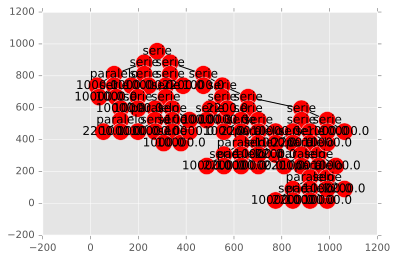

In [17]:
show_expressao(hall_of_fame[0])

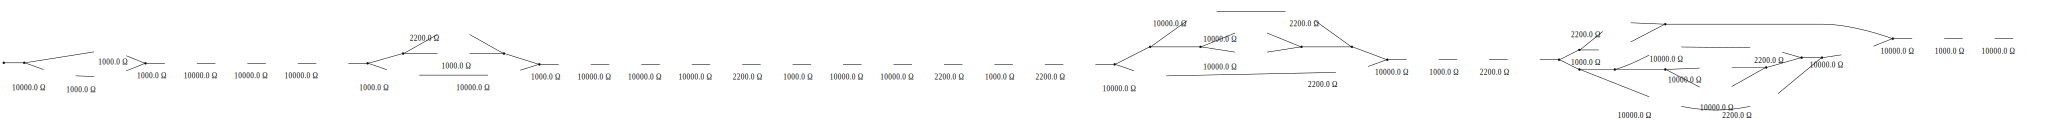

In [18]:
from circuit_drawer import GeapGraphGenerator

GeapGraphGenerator.by_expression(hall_of_fame[0]).generate().draw()

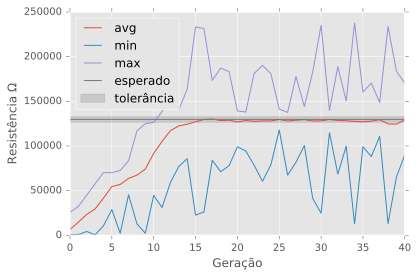

In [19]:
gen = log.select("gen")
avg, minimo, maximo = log.chapters['resistencia'].select("avg", "min", "max")

plt.plot(gen, avg, label="avg")
plt.plot(gen, minimo, label="min")
plt.plot(gen, maximo, label="max")

plt.plot([0, NUMERO_GERACOES], [resistencia_equivalente, resistencia_equivalente], label='esperado')

equivalente_range_1 = 2 * [resistencia_equivalente * (1-.025)]
equivalente_range_2 = 2 * [resistencia_equivalente * (1+.025)]

plt.fill_between([0, NUMERO_GERACOES], equivalente_range_1, equivalente_range_2, color='k', alpha=.125, label='tolerância')

plt.xlabel("Geração")
plt.ylabel("Resistência Ω")
plt.legend(loc="best")

plt.show()

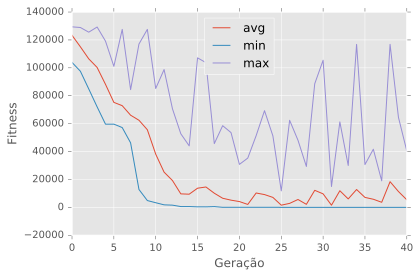

In [20]:
gen = log.select("gen")
avg, minimo, maximo = log.chapters['fitness'].select("avg", "min", "max")

plt.plot(gen, avg, label="avg")
plt.plot(gen, minimo, label="min")
plt.plot(gen, maximo, label="max")

plt.plot([0, gen[-1]], [-10000, -10000], alpha=0)  # Gambiarra para mostrar gráfico y < 0

plt.xlabel("Geração")
plt.ylabel("Fitness")
plt.legend(loc="best")

plt.show()